In [83]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
int_cols = ['data_size', 'batch_size', 'num_runs', 'num_workers','prefetch_factor']
float_cols = [
    'memory allocated (MB)',
    'memory reserved  (MB)', 
    'max memory allocated (MB)',
    'max memory reserved  (MB)', 
    'inference time per hundred frames',
    'std'
]
bool_cols = ['pin_memory', 'benchmark']

In [67]:
dfs = [pd.read_csv(csv, index_col=0).T for csv in Path('results/').glob('result_*.csv')]
df = pd.concat(dfs).reset_index(drop=True)

# Processing data type
for cols, dtype in zip([int_cols, float_cols], ['int', 'float']):
    for col in cols:
        df[col] = df[col].astype(dtype)
for col in bool_cols:
    df[col] = df[col].map({'True': True, 'False': False})

df.to_csv('results/inference_time_combined.csv', float_format='%.6f')
df.head(5)

,data_size,batch_size,num_runs,pin_memory,num_workers,prefetch_factor,benchmark,memory allocated (MB),memory reserved (MB),max memory allocated (MB),max memory reserved (MB),inference time per hundred frames,std
0,512,8,10,True,8,2,True,1.500488,268.0,258.001465,268.0,0.314745,0.016661
1,512,64,10,True,12,2,True,6.422363,2422.0,2053.176270,2422.0,0.447351,0.022316
2,512,128,10,False,1,2,False,12.047363,4840.0,4106.055176,4840.0,0.336070,0.003340
3,512,2,10,False,4,2,False,0.973145,86.0,66.435059,86.0,0.348895,0.009765
4,512,32,10,False,8,1,True,3.609863,1212.0,1027.611816,1212.0,0.355362,0.013205


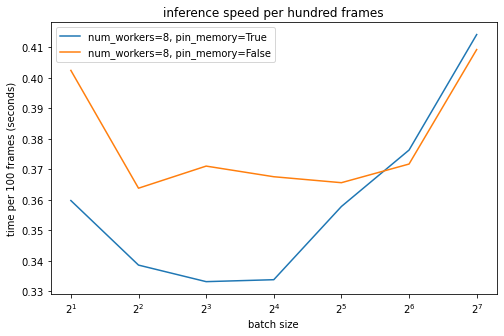

In [125]:
def query(df, params, targets=None):
    for key in params:
        if params[key] is None:
            params[key] = df[key].unique()
    configs = ParameterGrid(params)
    
    def get_name(config):
        return ', '.join([f'{key}={val}' for key, val in config.items()])
    
    result = {}
    for config in configs:
        name = get_name(config)
        qry = ' & '.join([f"{key} == {value}" for key,value in config.items()])
        subset = df.query(qry)
        # print(subset)
        if targets:
            subset = subset[targets]
        result[name] = subset
    return result

def plot(dfs, x, y, save_fname=None):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    for name, df in dfs.items():
        df = df.groupby(x).mean().reset_index()
        df.sort_values(x, inplace=True)
        ax.plot(df[x], df[y], label=name)
        ax.set_xscale('log', base=2)
    plt.legend()
    plt.xlabel('batch size')
    plt.ylabel('time per 100 frames (seconds)')
    plt.title('inference speed per hundred frames')
    
    if save_fname:
        plt.savefig(save_fname, bbox_inches='tight', dpi=200)

params = {
    'num_workers': [8], 
    'pin_memory': None, 
    # 'benchmark': None, 
    # 'prefetch_factor': None
}
x = 'batch_size'
y = 'inference time per hundred frames'
plot(
    query(df, params, [x, y]), 
    x='batch_size', 
    y='inference time per hundred frames', 
    save_fname='results/inference_time.png'
)

,data_size,batch_size,num_runs,pin_memory,num_workers,prefetch_factor,benchmark,memory allocated (MB),memory reserved (MB),max memory allocated (MB),max memory reserved (MB),inference time per hundred frames,std
